# Cargando imagenes

In [ ]:
import os
import cv2
import random
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

Data agumentation

In [ ]:
# Count images in each folder
benign_dir = '/content/drive/MyDrive/dataset/train_val/benign'
malignant_dir = '/content/drive/MyDrive/dataset/train_val/malignant'

num_benign = len(os.listdir(benign_dir))
num_malignant = len(os.listdir(malignant_dir))

print(f"Number of benign images: {num_benign}")
print(f"Number of malignant images: {num_malignant}")

# Calculate how many images are needed to balance the dataset
num_to_generate = num_malignant - num_benign
print(f"Number of images to generate: {num_to_generate}")

Number of benign images: 2233
Number of malignant images: 4926
Number of images to generate: 2693


In [ ]:
num_benign+num_malignant

7159

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Create the ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    #rotation_range=20,          # Rotate images by 20 degrees
    #width_shift_range=0.2,      # Shift horizontally by 20%
    #height_shift_range=0.2,     # Shift vertically by 20%
    #shear_range=0.2,            # Apply shearing transformations
    zoom_range=0.2,             # Zoom in/out by 20%
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest'         # Fill in empty pixels with nearest values
)

In [ ]:
# Create output folder if it doesn't exist
output_dir = '/content/drive/MyDrive/dataset/train_val/benign/generated'
os.makedirs(output_dir, exist_ok=True)

# Generate synthetic images
count = 0
for filename in os.listdir(benign_dir):
    if count >= num_to_generate:  # Stop when enough images are generated
        break

    # Load the image
    img_path = os.path.join(benign_dir, filename)
    img = load_img(img_path)  # Load image as PIL object
    img_array = img_to_array(img)  # Convert to NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Generate augmented images
    for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_dir,
                              save_prefix='aug', save_format='png'):
        count += 1
        if count >= num_to_generate:  # Stop when enough images are generated
            break

print(f"Generated {count} synthetic images in {output_dir}.")

Generated 2693 synthetic images in /content/drive/MyDrive/dataset/train_val/benign/generated.


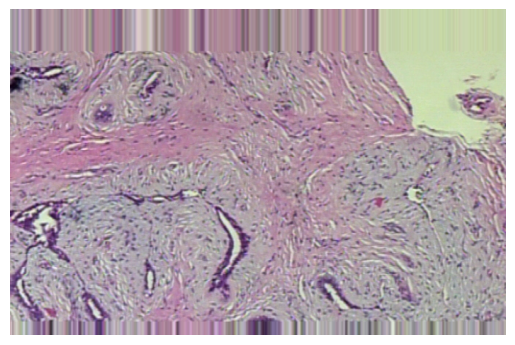

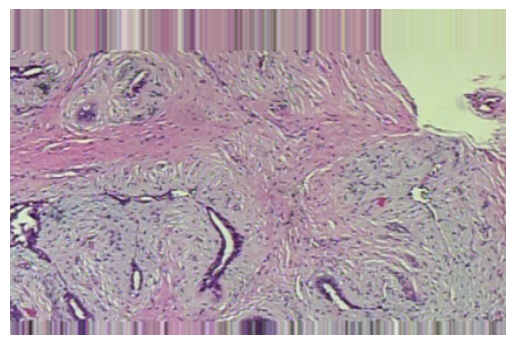

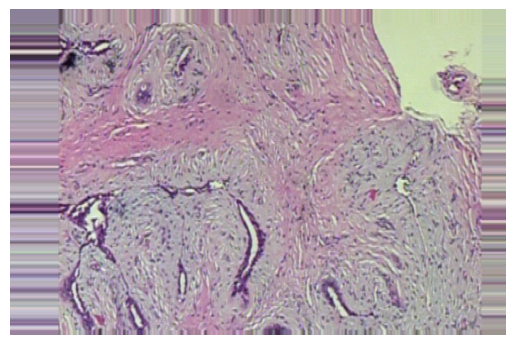

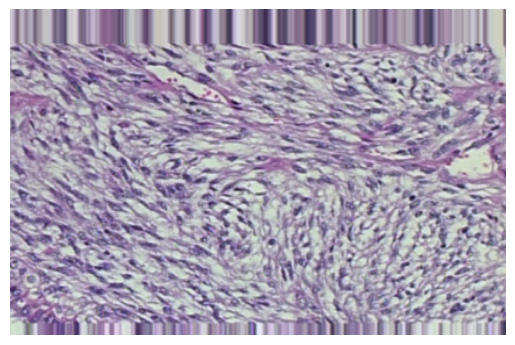

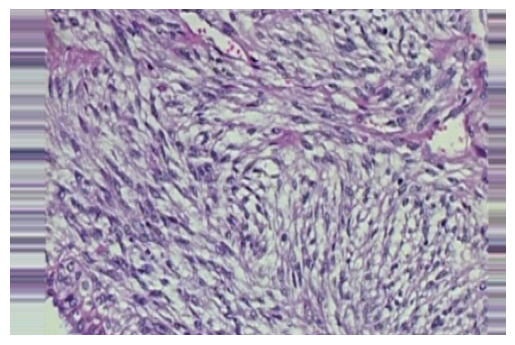

In [ ]:
import matplotlib.pyplot as plt

# Display some generated images
generated_images = os.listdir(output_dir)
for i in range(5):  # Display first 5 images
    img_path = os.path.join(output_dir, generated_images[i])
    img = load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
len(generated_images)

4140

Data load for training

In [ ]:
#Imagenes para el entrenamiento
trains_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset/train_val',
    validation_split=0.2,
    subset = "training",
    seed=123,
    image_size=(224,224)
)

Found 8544 files belonging to 2 classes.
Using 6836 files for training.


In [ ]:
#Imagenes para la validacion
val_ds = tf.keras.utils.image_dataset_from_directory(
     '/content/drive/MyDrive/dataset/train_val',
    validation_split=0.2,
    subset = "validation",
    seed=123,
    image_size=(224,224)
)

Found 8544 files belonging to 2 classes.
Using 1708 files for validation.


In [ ]:
#Aqui podemos verificar cuales son las clases de nuestro dataset
class_names = trains_ds.class_names
print(class_names)

['benign', 'malignant']


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset/test',
    image_size=(224, 224),  # Resize images to a standard size
    batch_size=32,          # Adjust batch size as needed
    shuffle=False           # Usually shuffle is False for test sets
)

Found 796 files belonging to 2 classes.


In [ ]:
print(test_ds.class_names)

['benign', 'malignant']


# Análisis exploratorio de los datos

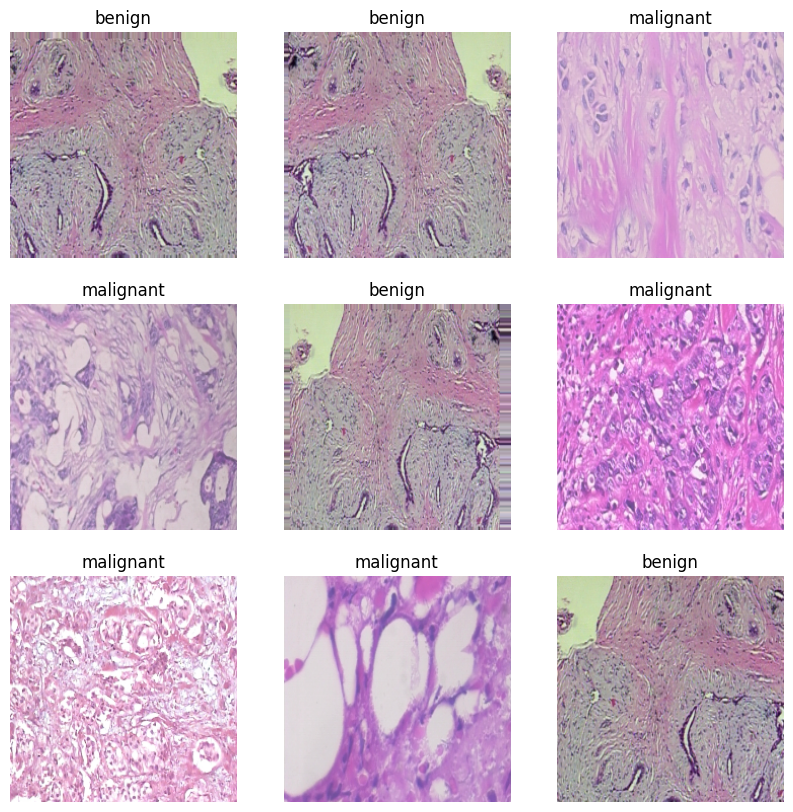

In [ ]:
#Vemos las imagenes
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in trains_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
import tensorflow as tf

def calculate_class_distribution(dataset, class_names):
    # Extract labels from the dataset
    labels = tf.concat([y for _, y in dataset], axis=0)

    # Count occurrences of each class
    class_counts = tf.math.bincount(labels, minlength=len(class_names)).numpy()

    # Print total images and per-class distribution
    total_images = sum(class_counts)
    print(f"Total images: {total_images}")
    for idx, count in enumerate(class_counts):
        print(f"Images in class '{class_names[idx]}': {count} ({(count / total_images) * 100:.2f}%)")

In [ ]:
# Example usage
class_names = ['benign', 'malignant']
calculate_class_distribution(trains_ds, class_names)

Total images: 10156
Images in class 'benign': 6233 (61.37%)
Images in class 'malignant': 3923 (38.63%)


Porcentaje de imagenes benignas: 31.13322856643967
Porcentaje de imagenes malignas: 68.86677143356033


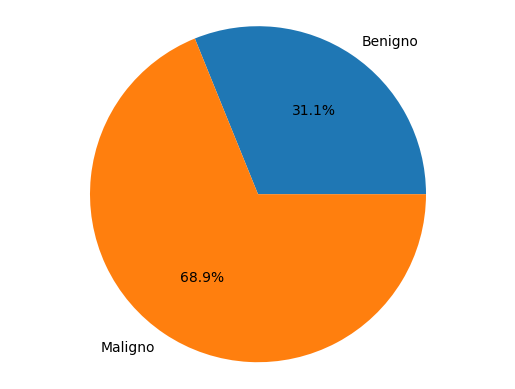

In [ ]:
#Para el entrenamiento
imagenes_beningnas = 1783
imagenes_malignas = 3944
total_de_imagenes = 5727
porcentaje_benigno = (imagenes_beningnas/total_de_imagenes)*100
porcentaje_maligno = (imagenes_malignas/total_de_imagenes)*100
print(f'Porcentaje de imagenes benignas: {porcentaje_benigno}')
print(f'Porcentaje de imagenes malignas: {porcentaje_maligno}')

#Hacemos un histograma:
labels = ['Benigno', 'Maligno']
sizes = [porcentaje_benigno, porcentaje_maligno]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [ ]:
#Verificamos que el tamaño de las imagenes sea el correcto
for image_batch, labels_batch in trains_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
total_samples = sum(1 for _ in trains_ds.unbatch())
print(f"Total samples: {total_samples}")

KeyboardInterrupt: 

# Modelo Miau 0

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir la arquitectura de la CNN
model = models.Sequential([
    # Primera capa convolucional
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Entrada 224x224x3
    layers.MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Tercera capa convolucional
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Capa de aplanamiento (Flatten) para preparar la entrada a las capas densas
    layers.Flatten(),

    # Capa completamente conectada (Fully Connected)
    layers.Dense(128, activation='relu'),

    # Capa de salida con activación sigmoid para clasificación binaria
    layers.Dense(1, activation='sigmoid')  # Una única neurona para salida binaria
])

# Compilar el modelo

adam_optimizer = Adam(learning_rate=0.000005)

model.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',  # Pérdida para clasificación binaria
    metrics=['accuracy']  # Métrica de desempeño
)

# Resumen del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Definir hiperparámetros
epochs = 50  # Número de épocas (puedes ajustar este valor)
batch_size = 32  # Debe coincidir con el usado en la generación del dataset

# Definir EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=5,  # Detiene el entrenamiento si no mejora después de 5 épocas
    restore_best_weights=True  # Restaura los pesos del modelo que dieron la mejor métrica
)


# Entrenar el modelo
history = model.fit(
    trains_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=len(trains_ds) // batch_size,  # Aproximado para tf.data.Dataset
    validation_steps=len(val_ds) // batch_size,
    callbacks=[early_stopping]  # Pasamos el callback
)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 193s 25s/step - accuracy: 0.5644 - loss: 5.5987 - val_accuracy: 0.5312 - val_loss: 3.8594
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.6359 - loss: 1.7923 - val_accuracy: 0.6094 - val_loss: 1.6317
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 69s 9s/step - accuracy: 0.6721 - loss: 1.4697 - val_accuracy: 0.7656 - val_loss: 1.0718
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - accuracy: 0.8027 - loss: 1.1078 - val_accuracy: 0.8438 - val_loss: 0.7304
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 67s 9s/step - accuracy: 0.7889 - loss: 1.3919 - val_accuracy: 0.7812 - val_loss: 0.7433
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 65s 8s/step - accuracy: 0.7800 - loss: 0.8604 - val_accuracy: 0.7969 - val_loss: 0.6238
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - accuracy: 0.7721 - loss: 0.9540 - val_accuracy: 0.9219 - val_loss: 0.2191
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 8s/step - accuracy: 0.8406 - loss: 0.7266 - val_accuracy: 0.8750 - val_loss: 0.5842
Epoch 

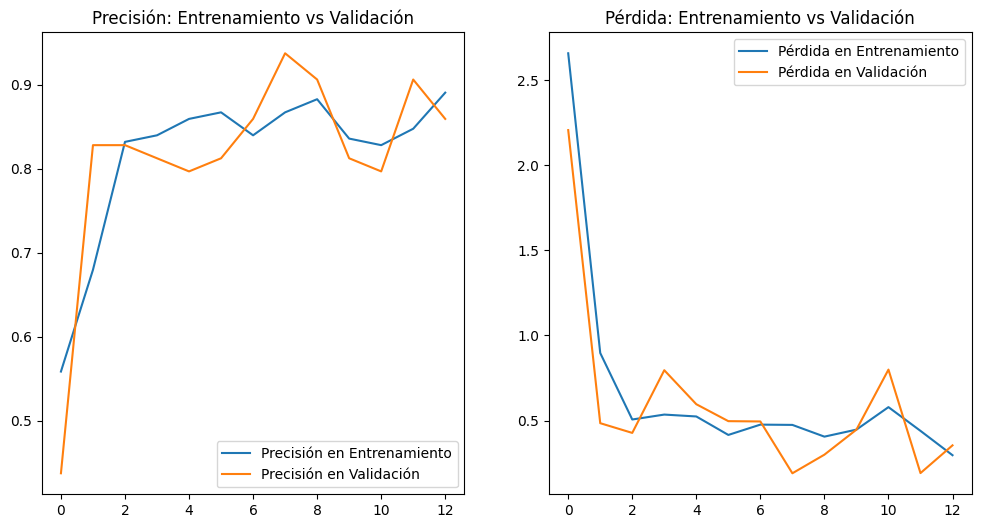

In [ ]:
import matplotlib.pyplot as plt

# Historial de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Número de épocas (debe ser el mismo que definiste)
epochs_range = range(len(acc))

# Crear las gráficas
plt.figure(figsize=(12, 6))

# Graficar precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión en Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión en Validación')
plt.legend(loc='lower right')
plt.title('Precisión: Entrenamiento vs Validación')

# Graficar pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida en Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida en Validación')
plt.legend(loc='upper right')
plt.title('Pérdida: Entrenamiento vs Validación')

plt.show()



In [ ]:
#Evaluamos el modelo con la metrica Recall
test_loss, test_recall = model.evaluate(test_ds)
print(f"Test recall: {test_recall:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 279s 11s/step - accuracy: 0.6814 - loss: 1.6398
Test recall: 0.7739


In [ ]:
# Guardamos el modelo
model.save('/content/drive/MyDrive/cancer_modelo_miau_1_da.h5')

# Creamos la red neuronal 2


Este fue el segundo modelo que hicimos. El cual tiene tres capas convolucionales y tiene una función de perdida.

In [ ]:
#Creamos nuestro segundo modelo
num_clases=len(class_names)

modelo_final = Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    #capa 1
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    #Capa 2
    layers.Conv2D(64 , 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])


In [ ]:
# Compilar el modelo
adam_optimizer = Adam(learning_rate=0.000005)  # Default is 0.001; try smaller values like 0.0001

modelo_final.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',  # Pérdida para clasificación binaria
    metrics=['accuracy']  # Métrica de desempeño
)

In [ ]:
#Vemos la estructura del modelo
modelo_final.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,521 (91.20 MB)

 Trainable params: 23,907,521 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo 2

In [ ]:
# Definir hiperparámetros
epochs = 50  # Número de épocas (puedes ajustar este valor)
batch_size = 32  # Debe coincidir con el usado en la generación del dataset

# Definir EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=5,  # Detiene el entrenamiento si no mejora después de 5 épocas
    restore_best_weights=True  # Restaura los pesos del modelo que dieron la mejor métrica
)


# Entrenar el modelo
history = modelo_final.fit(
    trains_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=len(trains_ds) // batch_size,  # Aproximado para tf.data.Dataset
    validation_steps=len(val_ds) // batch_size,
    callbacks=[early_stopping]  # Pasamos el callback
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.4908 - loss: 0.7007 - val_accuracy: 0.5000 - val_loss: 0.6873
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.5755 - loss: 0.6810 - val_accuracy: 0.4375 - val_loss: 0.7088
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.5305 - loss: 0.6850 - val_accuracy: 0.7500 - val_loss: 0.6670
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.6266 - loss: 0.6600 - val_accuracy: 0.5156 - val_loss: 0.6498
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.6416 - loss: 0.6494 - val_accuracy: 0.6875 - val_loss: 0.6531
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.6717 - loss: 0.6467 - val_accuracy: 0.5312 - val_loss: 0.6366
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.6389 - loss: 0.6146 - val_accuracy: 0.5469 - val_loss: 0.6481
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.6139 - loss: 0.6442 - val_accuracy: 0.8438 - val_loss: 0.5937
Epoch 9/

#Evaluamos el modelo 2

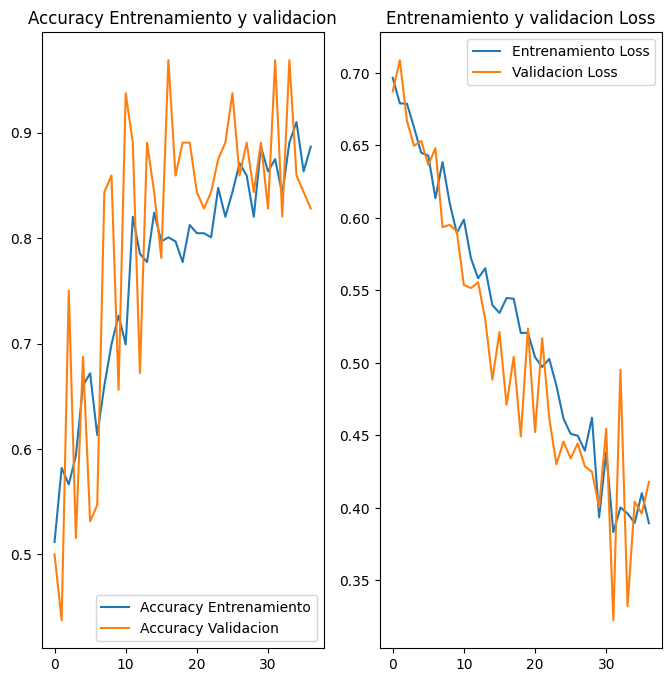

In [ ]:
#Visualizamos el rendimiento del modelo 1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range is now based on the actual number of epochs trained
# Use the minimum length between acc and val_acc to ensure they match
epochs_range = range(min(len(acc), len(val_acc)))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc[:len(epochs_range)],label='Accuracy Entrenamiento') # Slice acc to match epochs_range
plt.plot(epochs_range,val_acc,label='Accuracy Validacion')
plt.legend(loc='lower right')
plt.title('Accuracy Entrenamiento y validacion')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss[:len(epochs_range)],label='Entrenamiento Loss') # Slice loss to match epochs_range
plt.plot(epochs_range,val_loss,label='Validacion Loss')
plt.legend(loc='upper right')
plt.title('Entrenamiento y validacion Loss')
plt.show()

In [ ]:
#Evaluamos el modelo con la metrica Recall
test_loss, test_recall = modelo_final.evaluate(val_ds)
print(f"Test recall: {test_recall:.4f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8587 - loss: 0.4052
Test recall: 0.8730


In [ ]:
#Cargamos uuna imagen para realizar una prediccion
imagen_path = '/content/drive/MyDrive/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-001.png'
imagen = tf.keras.preprocessing.image.load_img(imagen_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(imagen)
input_arr = np.array([input_arr])
predictions = modelo_final.predict(input_arr)

#Imprimimos la prediccion
score = tf.nn.softmax(predictions[0])
print(
    "Esta imagen parece ser {} con un {:.2f} % de exactitud."
    .format(class_names[np.argmax(score)],100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Esta imagen parece ser benign con un 100.00 % de exactitud.


In [ ]:
# Guardamos el modelo
modelo_final.save('/content/drive/MyDrive/cancer_modelo_fina.h5')

# **MODELO FINAL SELECCIONADO:** Transferencia de conocimiento

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Cargar el modelo base preentrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base (no entrenables)
base_model.trainable = False

# Construir la red con capas personalizadas
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),  # Capa completamente conectada
    Dropout(0.5),                   # Regularización para evitar sobreajuste
    Dense(2)  # Capa de salida para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()  # Mostrar la arquitectura del modelo


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,278,594 (187.98 MB)

 Trainable params: 25,690,882 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Definir EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=5,  # Detiene el entrenamiento si no mejora después de 5 épocas
    restore_best_weights=True  # Restaura los pesos del modelo que dieron la mejor métrica
)


history = model.fit(
    trains_ds,
    validation_data=val_ds,
    epochs=10,  # Puedes ajustar según resultados
    steps_per_epoch=len(trains_ds),  # Aproximado para tf.data.Dataset
    validation_steps=len(val_ds),
    callbacks=[early_stopping]  # Pasamos el callback
)

Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1820s 8s/step - accuracy: 0.7812 - loss: 4.4123 - val_accuracy: 0.8724 - val_loss: 0.2889
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 150ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


214/214 ━━━━━━━━━━━━━━━━━━━━ 1829s 8s/step - accuracy: 0.8836 - loss: 0.2773 - val_accuracy: 0.8923 - val_loss: 0.2494
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1843s 8s/step - accuracy: 0.9081 - loss: 0.2219 - val_accuracy: 0.8958 - val_loss: 0.2548
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 51s 238ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1826s 8s/step - accuracy: 0.9117 - loss: 0.1999 - val_accuracy: 0.9034 - val_loss: 0.2484
Epoch 8/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 50s 233ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1781s 8s/step - accuracy: 0.9195 - loss: 0.1764 - val_accuracy: 0.8964 - val_loss: 0.2419
Epoch 10/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 52s 244ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


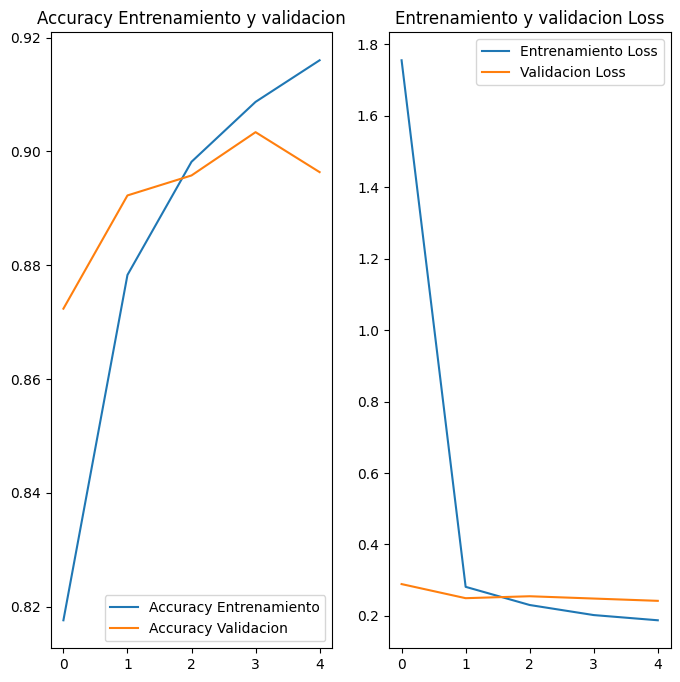

In [ ]:
#Visualizamos el rendimiento del modelo 1
acc = [history.history['accuracy'][0],history.history['accuracy'][2],history.history['accuracy'][4],history.history['accuracy'][6],history.history['accuracy'][8]]
val_acc = history.history['val_accuracy']

loss = [history.history['loss'][0],history.history['loss'][2],history.history['loss'][4],history.history['loss'][6],history.history['loss'][8]]
val_loss = history.history['val_loss']

# epochs_range is now based on the actual number of epochs trained
# Use the minimum length between acc and val_acc to ensure they match
epochs_range = range(min(len(acc), len(val_acc)))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc[:len(epochs_range)],label='Accuracy Entrenamiento') # Slice acc to match epochs_range
plt.plot(epochs_range,val_acc,label='Accuracy Validacion')
plt.legend(loc='lower right')
plt.title('Accuracy Entrenamiento y validacion')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss[:len(epochs_range)],label='Entrenamiento Loss') # Slice loss to match epochs_range
plt.plot(epochs_range,val_loss,label='Validacion Loss')
plt.legend(loc='upper right')
plt.title('Entrenamiento y validacion Loss')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/cancer_modelo_trans_1.h5')

#Creación de la red neuronal 3


In [ ]:
#Creamos nuestro tercer modelo
num_clases=len(class_names)

modelo_3 = Sequential([
 layers.Rescaling(1./255, input_shape=(224,224,3)),

 #Primera capa de convolucion:
 layers.Conv2D(64,3,padding='same',activation='relu'),
 layers.MaxPooling2D(),
 #Segunda capa convolucional:
 layers.Conv2D(64,3,padding='same',activation='relu'),
 layers.MaxPooling2D(),

 #Perdida
 layers.Dropout(0.4),
 #Aplanamos las dinemciones
 layers.Flatten(),

 #Red
 layers.Dense(128,activation='relu'),
 layers.Dense(num_clases)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Compilamos el modelo
modelo_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Vemos la estructura del modelo
modelo_3.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

#Entrenamiento del modelo 3

In [ ]:
#Entrenamiento del modelo 1
epocas = 20
history = modelo_3.fit(
    trains_ds,
    validation_data=val_ds,
    epochs=epocas
)

Epoch 1/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 1380s 7s/step - accuracy: 0.6804 - loss: 0.8110 - val_accuracy: 0.8415 - val_loss: 0.4627
Epoch 2/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 1404s 7s/step - accuracy: 0.8015 - loss: 0.4698 - val_accuracy: 0.8522 - val_loss: 0.4166
Epoch 3/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 1344s 7s/step - accuracy: 0.8321 - loss: 0.4207 - val_accuracy: 0.8572 - val_loss: 0.4341
Epoch 4/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 1342s 7s/step - accuracy: 0.8352 - loss: 0.4179 - val_accuracy: 0.8465 - val_loss: 0.4126
Epoch 5/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 1328s 7s/step - accuracy: 0.8457 - loss: 0.3976 - val_accuracy: 0.8660 - val_loss: 0.3693
Epoch 6/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 1389s 7s/step - accuracy: 0.8544 - loss: 0.3785 - val_accuracy: 0.8497 - val_loss: 0.4201


#Evaluamos el modelo 3


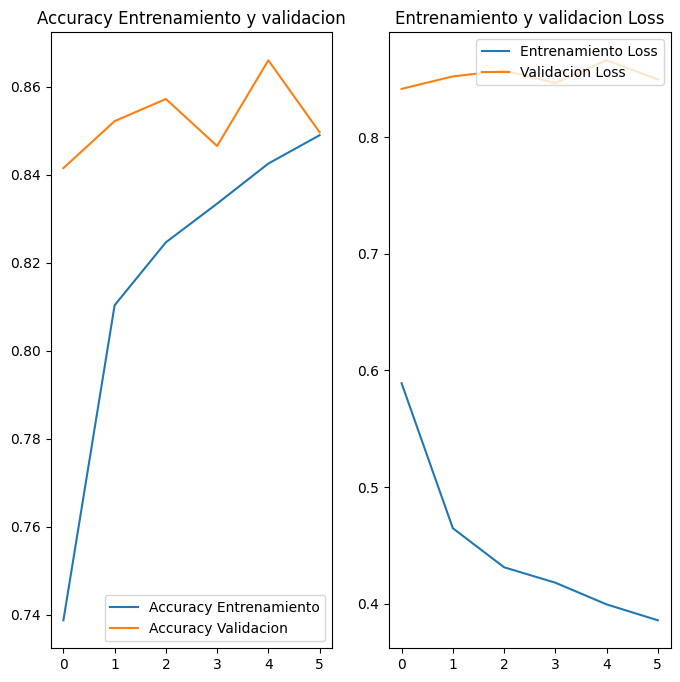

In [ ]:
#Visualizamos el rendimiento del modelo 3
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epocas)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy Entrenamiento')
plt.plot(epochs_range,val_acc,label='Accuracy Validacion')
plt.legend(loc='lower right')
plt.title('Accuracy Entrenamiento y validacion')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Entrenamiento Loss')
plt.plot(epochs_range,val_acc,label='Validacion Loss')
plt.legend(loc='upper right')
plt.title('Entrenamiento y validacion Loss')
plt.show()

In [ ]:
#Evaluamos el modelo con la metrica Recall
test_loss, test_recall = modelo_3.evaluate(val_ds)
print(f"Test recall: {test_recall:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8430 - loss: 0.4261
Test recall: 0.8497


In [ ]:
#Cargamos uuna imagen para realizar una prediccion
imagen_path = '/content/drive/MyDrive/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-001.png'
imagen = tf.keras.preprocessing.image.load_img(imagen_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(imagen)
input_arr = np.array([input_arr])
predictions = modelo_3.predict(input_arr)

#Imprimimos la prediccion
score = tf.nn.softmax(predictions[0])
print(
    "Esta imagen parece ser {} con un {:.2f} % de exactitud."
    .format(class_names[np.argmax(score)],100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Esta imagen parece ser malignant con un 54.89 % de exactitud.


In [ ]:
# Guardamos el modelo
modelo_3.save('/content/drive/MyDrive/cancer_modelo_3.h5')

# Modelo 4

In [ ]:
#Creamos nuestro cuarto modelo
num_clases=len(class_names)

modelo_4 = Sequential([

 layers.Rescaling(1./255, input_shape=(224,224,3)),

 #Primera capa de convolucion:
 layers.Conv2D(64,3,padding='same',activation='relu'),
 layers.MaxPooling2D(),
 #Perdida
 layers.Dropout(0.2),
 #Segunda capa convolucional:
 layers.Conv2D(64,3,padding='same',activation='relu'),
 layers.MaxPooling2D(),

 #Perdida
 layers.Dropout(0.2),
 #Aplanamos las dinemciones
 layers.Flatten(),
 #Red
 layers.Dense(64,activation='relu'),
 layers.Dense(num_clases)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Compilamos el modelo
modelo_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Vemos la estructura del modelo
modelo_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      12,845,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,651,912 (147.45 MB)

 Trainable params: 12,883,970 (49.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,767,942 (98.30 MB)

In [ ]:
epocas = 8
history = modelo_4.fit(
    trains_ds,
    validation_data=val_ds,
    epochs=epocas
)

Epoch 1/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1187s 6s/step - accuracy: 0.7743 - loss: 0.4966 - val_accuracy: 0.7748 - val_loss: 0.4944
Epoch 2/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1214s 6s/step - accuracy: 0.7904 - loss: 0.4687 - val_accuracy: 0.8327 - val_loss: 0.4397
Epoch 3/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1213s 6s/step - accuracy: 0.8199 - loss: 0.4393 - val_accuracy: 0.8409 - val_loss: 0.4642
Epoch 4/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1169s 6s/step - accuracy: 0.8317 - loss: 0.4261 - val_accuracy: 0.8421 - val_loss: 0.4320
Epoch 5/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1262s 6s/step - accuracy: 0.8350 - loss: 0.4127 - val_accuracy: 0.8497 - val_loss: 0.4205
Epoch 6/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1183s 6s/step - accuracy: 0.8420 - loss: 0.3912 - val_accuracy: 0.8484 - val_loss: 0.4024
Epoch 7/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1221s 6s/step - accuracy: 0.8432 - loss: 0.3884 - val_accuracy: 0.8497 - val_loss: 0.3957
Epoch 8/8
199/199 ━━━━━━━━━━━━━━━━━━━━ 1219s 6s/step - accuracy: 0.8570 - loss: 0.3555 - val_accu

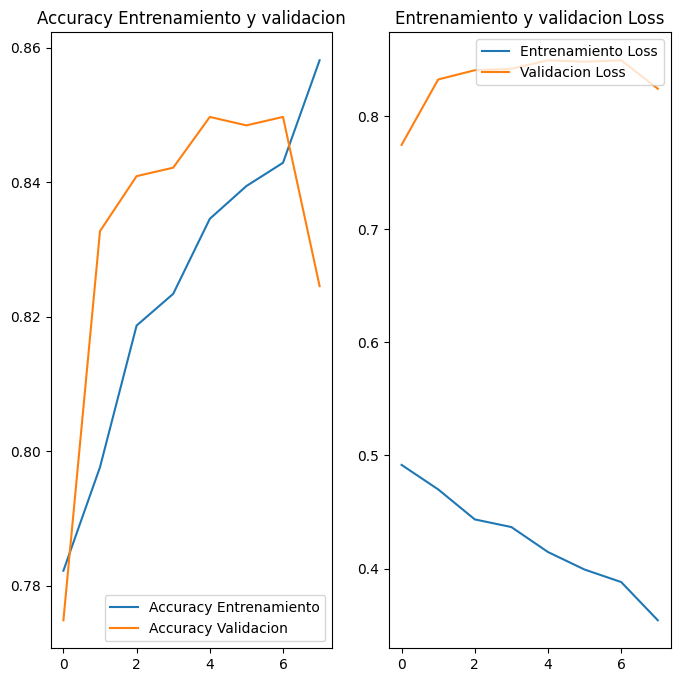

In [ ]:
#Visualizamos el rendimiento del modelo 3
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epocas)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy Entrenamiento')
plt.plot(epochs_range,val_acc,label='Accuracy Validacion')
plt.legend(loc='lower right')
plt.title('Accuracy Entrenamiento y validacion')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Entrenamiento Loss')
plt.plot(epochs_range,val_acc,label='Validacion Loss')
plt.legend(loc='upper right')
plt.title('Entrenamiento y validacion Loss')
plt.show()

In [ ]:
#Evaluamos el modelo con la metrica Recall
test_loss, test_recall = modelo_4.evaluate(val_ds)
print(f"Test recall: {test_recall:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8257 - loss: 0.4307
Test recall: 0.8245


In [ ]:
#Cargamos uuna imagen para realizar una prediccion
imagen_path = '/content/drive/MyDrive/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-001.png'
imagen = tf.keras.preprocessing.image.load_img(imagen_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(imagen)
input_arr = np.array([input_arr])
predictions = modelo_4.predict(input_arr)

#Imprimimos la prediccion
score = tf.nn.softmax(predictions[0])
print(
    "Esta imagen parece ser {} con un {:.2f} % de exactitud."
    .format(class_names[np.argmax(score)],100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Esta imagen parece ser malignant con un 76.69 % de exactitud.


In [ ]:
# Guardamos el modelo
modelo_4.save('/content/drive/MyDrive/cancer_modelo_4.h5')